In [1]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.plot import set_dark_theme
from tqdm import tqdm

import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning

import warnings

warnings.filterwarnings("ignore", category=ResourceWarning)

colourOrangeBold = "\033[1m\033[38;5;208m"
colourReset = "\033[0m"

print(f"{colourOrangeBold}Version skforecast: {skforecast.__version__}{colourReset}")
print(f"{colourOrangeBold}Version scikit-learn: {sklearn.__version__}{colourReset}")
print(f"{colourOrangeBold}Version pandas: {pd.__version__}{colourReset}")
print(f"{colourOrangeBold}Version numpy: {np.__version__}{colourReset}")

import os
from pathlib import Path

project_root = Path().resolve()
while project_root.name != "Algothon-2025" and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Working directory set to:", os.getcwd())

set_dark_theme()

Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 2.2.5
Working directory set to: C:\Users\jense\IdeaProjects\Algothon-2025


Set Training, Cross Validation and Testing Splits

In [2]:
TRAIN_START = 20
TRAIN_END = 600
VAL_END = 675

Import our price data: Prices are what we are predicting

In [3]:
# PRICES DATA:
data = pd.read_csv("./sourceCode/prices.txt", sep=r'\s+', header=None)
print(f"{colourOrangeBold}Shape: {data.shape}{colourReset}")

Shape: (750, 50)


Add column names to prices data

In [4]:
data.index.name = 'day'
data.columns = [f"inst_{i}" for i in range(data.shape[1])]

Split data into correct splits

In [5]:
# DATA SPLITTING:
data_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
data_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
data_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation days : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test days       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


Plot prices data for a few instruments for fun

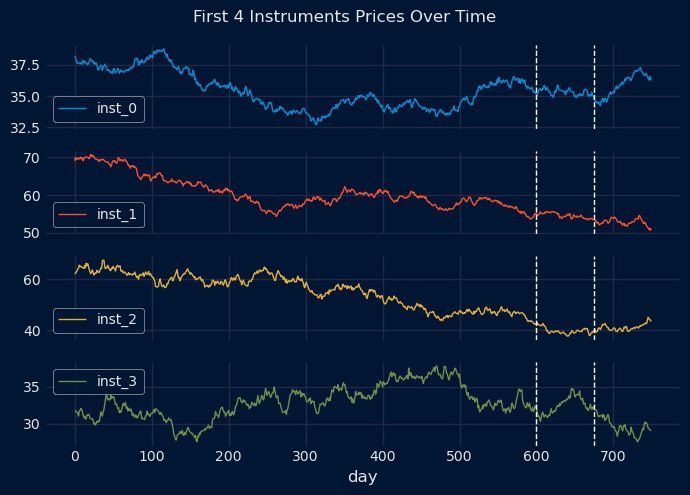

In [6]:
instrumentCount = 4

fig, axs = plt.subplots(instrumentCount, 1, figsize=(7, 5), sharex=True)
data.iloc[:, :instrumentCount].plot(
    legend=True,
    subplots=True,
    title='First 4 Instruments Prices Over Time',
    ax=axs,
    linewidth=1
)
# Add vertical lines at training and validation split
for ax in axs:
    ax.axvline(x=TRAIN_END, color='white', linestyle='--', linewidth=1)
    ax.axvline(x=VAL_END, color='white', linestyle='--', linewidth=1)
fig.tight_layout()
plt.show()

Train a forecaster that predicts prices for individual instruments for a baseline reference.

In [7]:
items = []
mse_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):
    # Define forecaster
    window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)

    forecaster = ForecasterRecursive(
        regressor=HistGradientBoostingRegressor(random_state=8523),
        lags=20,
        window_features=window_features
    )

    # Backtesting forecaster
    cv = TimeSeriesFold(
        steps=1,
        initial_train_size=len(data_train) + len(data_val),
        refit=False,
    )

    metric, preds = backtesting_forecaster(
        forecaster=forecaster,
        y=data[item],
        cv=cv,
        metric='mean_squared_error',
        show_progress=False
    )

    items.append(item)
    mse_values.append(metric.at[0, 'mean_squared_error'])
    predictions[item] = preds

# Results
uni_series_mse = pd.Series(
    data=mse_values,
    index=items,
    name='uni_series_mse'
)

print(f"{colourOrangeBold}========================{colourReset}")
print(uni_series_mse.head())
print(f"{colourOrangeBold}========================{colourReset}\n\n")


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

inst_0     0.076080
inst_1     2.329248
inst_2     1.341477
inst_3     0.198996
inst_4    37.198736
Name: uni_series_mse, dtype: float64




Train a global / multi time series predictor that takes into account instrument correlation (Evaluated with the same backtester as the single instrument predictor):

In [8]:
items = list(data.columns)

# Define forecaster
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=14)
forecaster_ms = ForecasterRecursiveMultiSeries(
    regressor           =GradientBoostingRegressor(random_state=8523), # ~ 20 seconds
    # regressor           =HistGradientBoostingRegressor(random_state=8523), # Much quicker, slightly less accurate, nan safe
    lags                =20,
    encoding            ='ordinal',
    transformer_series  =StandardScaler(),
    window_features     =window_features,
)

# Backtesting forecaster for all items
cv = TimeSeriesFold(
    initial_train_size  =len(data_train) + len(data_val),
    steps               =1,   # Predict 7 steps ahead
    refit               =True # Retrain at each split
)

multi_series_mse, predictions_ms = backtesting_forecaster_multiseries(
    forecaster          =forecaster_ms,
    series              =data,
    levels              =items,
    cv                  =cv,
    metric              ='mean_squared_error',
)

# Results
display(multi_series_mse.head(5))
display(predictions_ms.head(5))

predictions_ms = predictions_ms.reset_index()

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,0.025110
1,inst_1,0.113170
2,inst_2,0.254505
3,inst_3,0.123343
4,inst_4,0.141662


,level,pred
655,inst_0,35.017062
655,inst_1,54.346196
655,inst_2,40.058624
655,inst_3,34.021163
655,inst_4,46.178838


Compare the global to unique predictors:

In [9]:
multi_series_mse = multi_series_mse.set_index('levels')
multi_series_mse.columns = ['multi_series_mse']

results = pd.concat((uni_series_mse, multi_series_mse), axis=1)
results['improvement'] = results.eval('uni_series_mse - multi_series_mse')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mse - multi_series_mse) / uni_series_mse')
results = results.round(2)

display(results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))


,uni_series_mse,multi_series_mse,improvement,improvement_(%)
inst_0,0.080000,0.030000,0.050000,67.000000
inst_1,2.330000,0.110000,2.220000,95.140000
inst_2,1.340000,0.250000,1.090000,81.030000
inst_3,0.200000,0.120000,0.080000,38.020000
inst_4,37.200000,0.140000,37.060000,99.620000
inst_5,0.040000,0.030000,0.010000,26.690000
inst_6,0.230000,0.060000,0.170000,73.950000
inst_7,0.730000,0.360000,0.360000,50.150000
inst_8,0.280000,0.270000,0.010000,2.800000
inst_9,2.510000,0.480000,2.030000,80.830000


,improvement,improvement_(%)
mean,1.8106,59.2508
min,0.0100,2.8000
max,37.0600,99.6200


Using global predict:

,time,level,pred,actual
0,655,inst_0,35.017062,35.10
1,656,inst_0,35.095640,35.20
2,657,inst_0,35.212525,35.04
3,658,inst_0,35.031688,35.14
4,659,inst_0,35.146568,35.05
...,...,...,...,...
90,745,inst_0,36.494485,36.49
91,746,inst_0,36.490672,36.30
92,747,inst_0,36.286882,36.58
93,748,inst_0,36.583518,36.43


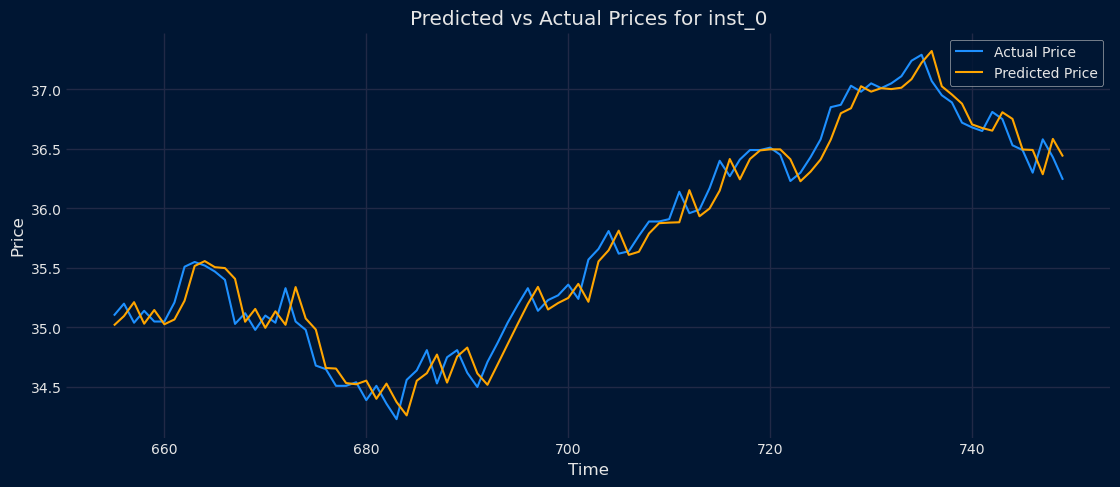

In [10]:
def plotPredictedVsActual(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = data[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")
    display(df_plot)
    # Step 4: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual Price", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted Price", color='orange')
    plt.title(f"Predicted vs Actual Prices for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


plotPredictedVsActual(predictions_ms, "inst_0")


Above looks decent but also a bit shite

**Now going to try adding more greeks to use in the model as exogenous features**


In [11]:
# Get exog features in a dictionary
greeksFilePaths = sorted(glob.glob("./greeks/greeksData_750Days/*.npy"))
feature_names = [os.path.splitext(os.path.basename(f))[0] for f in greeksFilePaths]

exog_array = np.stack([np.load(f) for f in greeksFilePaths], axis=-1)

exog_dict = {
    f"inst_{i}": pd.DataFrame(exog_array[:, i, :], columns=feature_names)
    for i in range(exog_array.shape[1])
}

print(f"{colourOrangeBold}Built exog_dict with {len(exog_dict)} instruments, each shape {exog_dict['inst_0'].shape}{colourReset}")
print("Features:", feature_names)

Built exog_dict with 50 instruments, each shape (750, 13)
Features: ['LaggedPrices_Lag=1_750_day_data', 'LaggedPrices_Lag=2_750_day_data', 'LaggedPrices_Lag=3_750_day_data', 'LaggedPrices_Lag=4_750_day_data', 'LaggedPrices_Lag=5_750_day_data', 'LogReturns_lookback=1_750_day_data', 'LogReturns_lookback=3_750_day_data', 'Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data']


Create our forecaster including these exogenous features


In [12]:
forecaster_ms_greeks = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = StandardScaler(),
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(data_train) + len(data_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks, predictions_ms_greeks = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks,
    series     = data,
    exog       = exog_dict,
    levels     = list(data.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks.head())
display(predictions_ms_greeks.head())

multi_series_mse_greeks = multi_series_mse_greeks.rename(columns={"mean_squared_error": "multi_series_mse_greeks"})
predictions_ms_greeks = predictions_ms_greeks.reset_index()
predictions_ms_greeks = predictions_ms_greeks.rename(columns={"index": "time"})

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,0.003120
1,inst_1,0.008017
2,inst_2,0.148676
3,inst_3,0.015270
4,inst_4,0.075169


,level,pred
655,inst_0,35.088373
655,inst_1,54.296815
655,inst_2,39.210068
655,inst_3,33.931230
655,inst_4,45.744419


Compare new predictions and plot new predictions vs Actual

In [13]:
multi_series_mse_greeks = multi_series_mse_greeks.set_index("levels")
# Join them
results_greeks = pd.concat((multi_series_mse, multi_series_mse_greeks), axis=1)

# Calculate improvements
results_greeks['improvement'] = results_greeks.eval('multi_series_mse - multi_series_mse_greeks')
results_greeks['improvement_(%)'] = 100 * results_greeks['improvement'] / results_greeks['multi_series_mse']
results_greeks = results_greeks.round(2)

# Display the goods
display(results_greeks.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results_greeks[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))

,multi_series_mse,multi_series_mse_greeks,improvement,improvement_(%)
levels,,,,
inst_0,0.030000,0.000000,0.020000,87.570000
inst_1,0.110000,0.010000,0.110000,92.920000
inst_2,0.250000,0.150000,0.110000,41.580000
inst_3,0.120000,0.020000,0.110000,87.620000
inst_4,0.140000,0.080000,0.070000,46.940000
inst_5,0.030000,0.000000,0.020000,89.580000
inst_6,0.060000,0.070000,-0.010000,-20.360000
inst_7,0.360000,0.010000,0.350000,96.720000
inst_8,0.270000,0.030000,0.240000,89.980000


,improvement,improvement_(%)
mean,0.201132,77.523585
min,-0.010000,-20.360000
max,1.620000,97.360000


,time,level,pred,actual
0,655,inst_0,35.088373,35.10
1,656,inst_0,35.182612,35.20
2,657,inst_0,35.101684,35.04
3,658,inst_0,35.095346,35.14
4,659,inst_0,35.084031,35.05
...,...,...,...,...
90,745,inst_0,36.480634,36.49
91,746,inst_0,36.382826,36.30
92,747,inst_0,36.431615,36.58
93,748,inst_0,36.481460,36.43


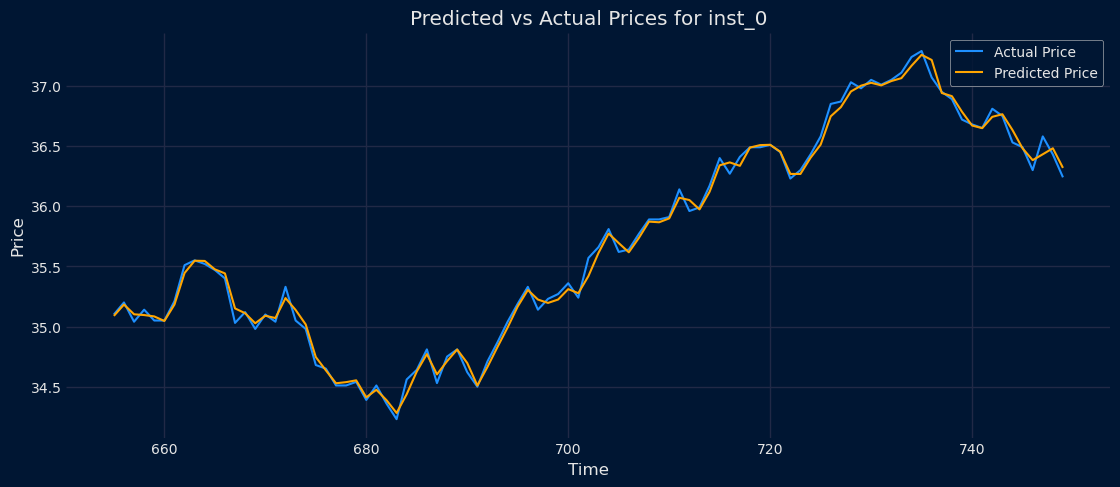

In [14]:
plotPredictedVsActual(predictions_ms_greeks, "inst_0")

# Now to try and predict log returns instead of prices:

In [15]:
logReturns_np = np.load("./greeks/greeksData_750Days/LogReturns_lookback=1_750_day_data.npy")
logReturns = pd.DataFrame(logReturns_np)

logReturns.columns = [f"inst_{i}" for i in range(logReturns.shape[1])]

print(f"{colourOrangeBold}Log returns shape = {colourReset}{logReturns.shape}")

Log returns shape = (750, 50)


Create exogenous data (now with prices, laggedPrices and without logReturns (logReturns is used in predictions by lag))

In [16]:
all_paths = sorted(glob.glob("./greeks/greeksData_750Days/*.npy"))

feature_paths = [
    p for p in all_paths
    if 'LogReturns' not in os.path.basename(p)
]

feature_names = [
    os.path.splitext(os.path.basename(p))[0]
    for p in feature_paths
]

exog_array = np.stack([np.load(p) for p in feature_paths], axis=-1)

price_array = data.to_numpy()
exog_array_with_price = np.concatenate(
    [exog_array, price_array[:, :, np.newaxis]],
    axis=-1
)
feature_names.append("price")

exog_dict_for_logReturns = {
    f"inst_{i}": pd.DataFrame(
        exog_array_with_price[:, i, :],
        columns=feature_names
    )
    for i in range(exog_array_with_price.shape[1])
}

print(f"Built exog_dict_for_logReturns with {len(exog_dict_for_logReturns)} instruments, each shape {exog_dict_for_logReturns['inst_0'].shape}")
print("Features:", feature_names)

Built exog_dict_for_logReturns with 50 instruments, each shape (750, 12)
Features: ['LaggedPrices_Lag=1_750_day_data', 'LaggedPrices_Lag=2_750_day_data', 'LaggedPrices_Lag=3_750_day_data', 'LaggedPrices_Lag=4_750_day_data', 'LaggedPrices_Lag=5_750_day_data', 'Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data', 'price']


Now split our data

In [17]:
logReturns_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
logReturns_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
logReturns_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {logReturns_train.index.min()} --- {logReturns_train.index.max()}  (n={len(logReturns_train)})")
print(f"Validation days : {logReturns_val.index.min()} --- {logReturns_val.index.max()}  (n={len(logReturns_val)})")
print(f"Test days       : {logReturns_test.index.min()} --- {logReturns_test.index.max()}  (n={len(logReturns_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


Now create this prediction model

In [18]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns, predictions_ms_greeks_logReturns = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns.head())
display(predictions_ms_greeks_logReturns.head())

multi_series_mse_greeks_logReturns = multi_series_mse_greeks_logReturns.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns"})
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.reset_index()
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_greeks_logReturns['multi_series_mse_greeks_logReturns'].mean()}")

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,7.328828e-07
1,inst_1,1.076139e-06
2,inst_2,1.261462e-05
3,inst_3,5.533487e-06
4,inst_4,1.504590e-06


,level,pred
655,inst_0,0.002198
655,inst_1,0.000972
655,inst_2,-0.006105
655,inst_3,-0.001815
655,inst_4,-0.003058


 Average MSE across instruments: 5.440716254681972e-06


And now plot our predicted log returns against the actual:

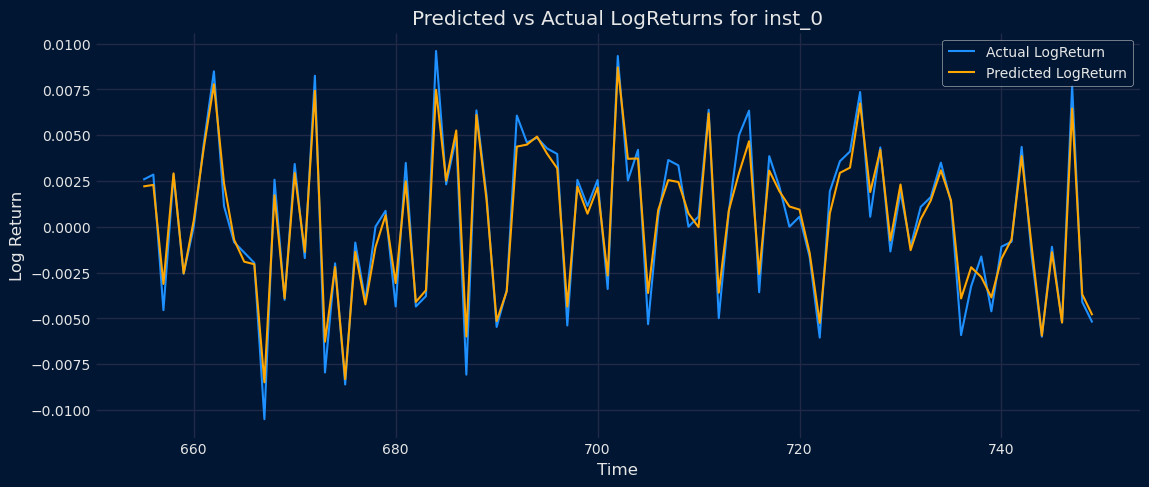

In [19]:
def plotPredictedVsActualLogReturns(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = logReturns[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual LogReturn", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted LogReturn", color='orange')
    plt.title(f"Predicted vs Actual LogReturns for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns, "inst_0")

 We will consider this an optimal result for prediction and a baseline for future reference

Convert predicted log returns to be the predicted next price. We can then compare this logReturns predicting model against our pricePredicting model/s

In [20]:
price_predict_from_logReturns = predictions_ms_greeks_logReturns.copy()

# Rename predicted log return column temporarily
price_predict_from_logReturns = price_predict_from_logReturns.rename(columns={"pred": "predicted_logReturn"})

# Reconstruct predicted price using previous day's actual price
def reconstruct_price(row):
    instrument = row['level']
    time = row['time']
    if time == 0:
        return np.nan  # Can't compute for first day
    prev_price = data.loc[time - 1, instrument]
    log_return = row['predicted_logReturn']
    return prev_price * np.exp(log_return)

# Apply the function to reconstruct price
price_predict_from_logReturns["pred"] = price_predict_from_logReturns.apply(reconstruct_price, axis=1)

# Drop the original log return prediction
price_predict_from_logReturns = price_predict_from_logReturns.drop(columns=["predicted_logReturn"])

display(price_predict_from_logReturns)

,time,level,pred
0,655,inst_0,35.087047
1,655,inst_1,54.272730
2,655,inst_2,39.706845
3,655,inst_3,33.928375
4,655,inst_4,45.719985
...,...,...,...
4745,749,inst_45,30.897131
4746,749,inst_46,86.796445
4747,749,inst_47,15.723096
4748,749,inst_48,80.571470


Compare

In [21]:
from sklearn.metrics import mean_squared_error

# Add actual prices from your price DataFrame (`data`)
price_predict_from_logReturns["actual"] = price_predict_from_logReturns.apply(
    lambda row: data.loc[row["time"], row["level"]],
    axis=1
)

predictions_ms_greeks["actual"] = predictions_ms_greeks.apply(
    lambda row: data.loc[row["time"], row["level"]],
    axis=1
)

mse_logReturns = price_predict_from_logReturns.groupby("level", group_keys=False).apply(
    lambda g: mean_squared_error(g["actual"], g["pred"]),
    include_groups=False
).reset_index(name="mse_logReturns")

mse_greeks = predictions_ms_greeks.groupby("level", group_keys=False).apply(
    lambda g: mean_squared_error(g["actual"], g["pred"]),
    include_groups=False
).reset_index(name="mse_greeks")

# Merge and compute improvements
mse_comparison = pd.merge(mse_logReturns, mse_greeks, on="level")
mse_comparison["improvement"] = mse_comparison["mse_greeks"] - mse_comparison["mse_logReturns"]
mse_comparison["improvement_(%)"] = 100 * mse_comparison["improvement"] / mse_comparison["mse_logReturns"]
mse_comparison = mse_comparison.round(4)

# Style output
display(mse_comparison.set_index("level").style.bar(
    subset=["improvement_(%)"], align="mid", color=["#d65f5f", "#5fba7d"]
))

# Summary stats
display(mse_comparison[["improvement", "improvement_(%)"]].agg(["mean", "min", "max"]))


,mse_logReturns,mse_greeks,improvement,improvement_(%)
level,,,,
inst_0,0.000900,0.003100,0.002200,234.662500
inst_1,0.003100,0.008000,0.005000,162.422900
inst_10,0.005800,0.004000,-0.001800,-30.650000
inst_11,0.028800,0.054000,0.025200,87.469200
inst_12,0.008400,0.012300,0.003900,46.929300
inst_13,0.004700,0.005100,0.000400,9.623400
inst_14,0.030500,0.076400,0.045900,150.596400
inst_15,0.003300,0.023100,0.019800,608.593000
inst_16,0.007400,0.064800,0.057400,773.061400


,improvement,improvement_(%)
mean,0.036792,495.504222
min,-0.021200,-50.419500
max,0.311300,2725.315100


Mostly big improvements from predicting prices to predicting log returns.


Having the model retrain every time will exceed the 10 minute running length in the competition, we need to modify. A few options:
- Change the regressor to HistGradientBoostingRegressor
- Turn off refit
- Somehow change refit to not refit everytime but instead every nth time

HIST GRADIENT BOOSTING:

In [22]:
forecaster_ms_greeks_logReturns_hgbr = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns_hgbr, predictions_ms_greeks_logReturns_hgbr = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns_hgbr,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns_hgbr.head())
display(predictions_ms_greeks_logReturns_hgbr.head())

multi_series_mse_greeks_logReturns_hgbr = multi_series_mse_greeks_logReturns_hgbr.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns_hgbr"})
predictions_ms_greeks_logReturns_hgbr = predictions_ms_greeks_logReturns_hgbr.reset_index()
predictions_ms_greeks_logReturns_hgbr = predictions_ms_greeks_logReturns_hgbr.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: { multi_series_mse_greeks_logReturns_hgbr['multi_series_mse_greeks_logReturns_hgbr'].mean()}")

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,2.826060e-07
1,inst_1,4.961846e-07
2,inst_2,4.760343e-06
3,inst_3,1.600702e-06
4,inst_4,6.365059e-07


,level,pred
655,inst_0,0.002239
655,inst_1,0.000769
655,inst_2,-0.006195
655,inst_3,-0.001915
655,inst_4,-0.003768


 Average MSE across instruments: 1.4996823429706059e-06


Compare HGBR to GBR (just using their log returns mse from now on because we will be predicting log returns)
:

In [23]:
def compareModelToBaseline(new_model_mse, baselineModel = multi_series_mse_greeks_logReturns_hgbr):
    # Join them
    results = pd.merge(
        baselineModel,
        new_model_mse,
        on="levels",
    )

    # Rename for clarity
    results.columns = ["level", "BASELINE_MSE", "NEW_MSE"]

    # Calculate improvement of new over GBR
    results["improvement"] = results["BASELINE_MSE"] - results["NEW_MSE"]
    results["improvement_(%)"] = 100 * results["improvement"] / results["BASELINE_MSE"]

    # Round and display
    results = results.round(4)
    display(results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
    display(results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))

compareModelToBaseline(multi_series_mse_greeks_logReturns_hgbr, multi_series_mse_greeks_logReturns)

,level,BASELINE_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,0.000000,61.439100
1,inst_1,0.000000,0.000000,0.000000,53.892200
2,inst_2,0.000000,0.000000,0.000000,62.263300
3,inst_3,0.000000,0.000000,0.000000,71.072500
4,inst_4,0.000000,0.000000,0.000000,57.695700
5,inst_5,0.000000,0.000000,0.000000,67.522900
6,inst_6,0.000000,0.000000,0.000000,73.594400
7,inst_7,0.000000,0.000000,0.000000,79.625000
8,inst_8,0.000000,0.000000,0.000000,65.243800
9,inst_9,0.000000,0.000000,0.000000,82.507100


,improvement,improvement_(%)
mean,0.0,70.20286
min,0.0,52.76090
max,0.0,85.26390


For some reason the HGBR is better than the GBR so lets use that as our new baseline


HGBR:


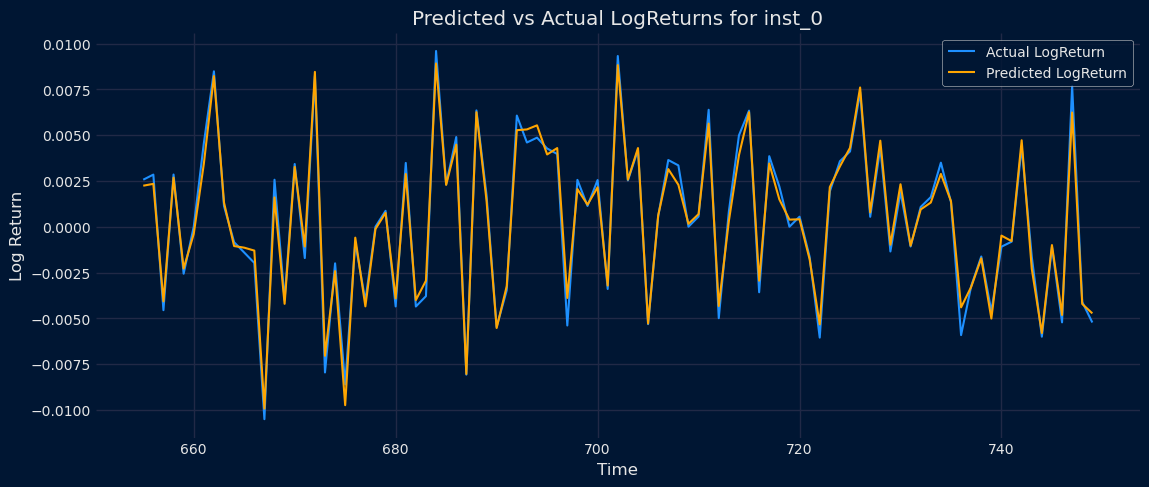

GBR:


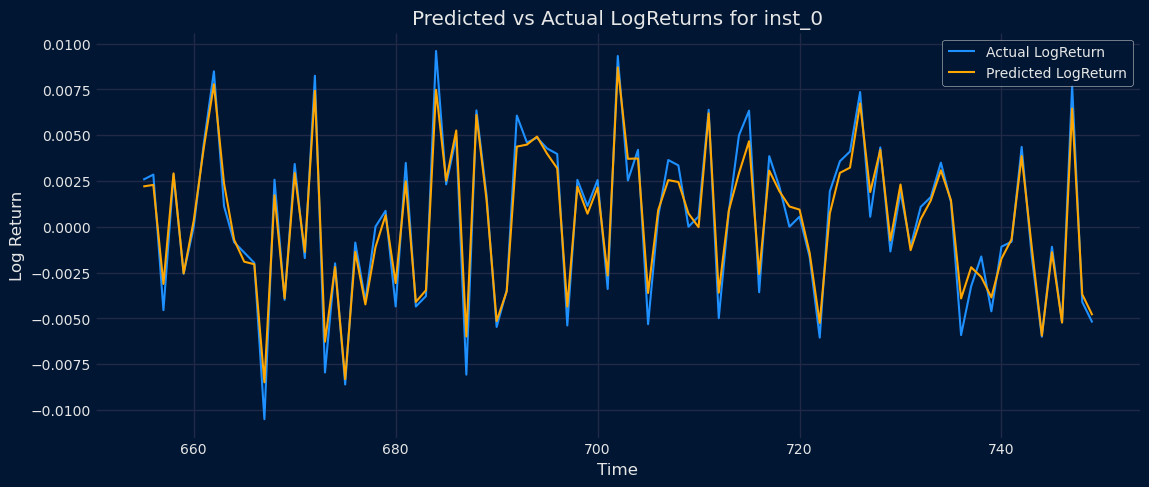

In [24]:
print("HGBR:")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns_hgbr, "inst_0")
print("GBR:")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns, "inst_0")

Now a model without refit

In [25]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = False
)

# Backtest
multi_series_mse_greeks_logReturns_noRefit, predictions_ms_greeks_logReturns_noRefit = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns_noRefit.head())
display(predictions_ms_greeks_logReturns_noRefit.head())

multi_series_mse_greeks_logReturns_noRefit = multi_series_mse_greeks_logReturns_noRefit.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns_noRefit"})
predictions_ms_greeks_logReturns_noRefit = predictions_ms_greeks_logReturns_noRefit.reset_index()
predictions_ms_greeks_logReturns_noRefit = predictions_ms_greeks_logReturns_noRefit.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_greeks_logReturns_noRefit['multi_series_mse_greeks_logReturns_noRefit'].mean()}")

  0%|          | 0/95 [00:00<?, ?it/s]

,levels,mean_squared_error
0,inst_0,6.627241e-07
1,inst_1,1.008866e-06
2,inst_2,1.170937e-05
3,inst_3,6.404734e-06
4,inst_4,1.288826e-06


,level,pred
655,inst_0,0.002198
655,inst_1,0.000972
655,inst_2,-0.006105
655,inst_3,-0.001815
655,inst_4,-0.003058


 Average MSE across instruments: 5.504863907985448e-06


Compare this to the best model:

In [26]:
print("Comparing new model of 'GBR no refit' VS 'HGBR with refit'")
compareModelToBaseline(multi_series_mse_greeks_logReturns_noRefit, multi_series_mse_greeks_logReturns_hgbr)

Comparing new model of 'GBR no refit' VS 'HGBR with refit'


,level,BASELINE_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,-0.000000,-134.504600
1,inst_1,0.000000,0.000000,-0.000000,-103.324700
2,inst_2,0.000000,0.000000,-0.000000,-145.977500
3,inst_3,0.000000,0.000000,-0.000000,-300.120400
4,inst_4,0.000000,0.000000,-0.000000,-102.484500
5,inst_5,0.000000,0.000000,-0.000000,-197.838200
6,inst_6,0.000000,0.000000,-0.000000,-316.721100
7,inst_7,0.000000,0.000000,-0.000000,-416.766700
8,inst_8,0.000000,0.000000,-0.000000,-192.439000
9,inst_9,0.000000,0.000000,-0.000000,-567.773400


,improvement,improvement_(%)
mean,0.0,-270.909636
min,-0.0,-596.845100
max,-0.0,-92.616700


Ok so its clear then that we should use HGBR as our primary choice. Now time for:

Adding some rolling window features
Allowed stats are:
- mean
- std
- min
- max
- sum
- median
- ratio_min_max
- coef_variation
- ewm

In [27]:
from sklearn.preprocessing import MinMaxScaler

window_features = RollingFeatures(
    stats           = ['min', 'max'],
    window_sizes    = 10,
)

window_features_forecaster = ForecasterRecursiveMultiSeries(
    regressor = HistGradientBoostingRegressor(random_state=8523),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags                = 20,
    window_features     = window_features,
)

window_features_forecaster.dropna_from_series = True

cv = TimeSeriesFold(
    initial_train_size  =len(logReturns_train) + len(logReturns_val),
    steps               =1,
    refit               =True
)

multi_series_mse_window, predictions_tuned_window = backtesting_forecaster_multiseries(
    forecaster  = window_features_forecaster,
    series      = logReturns,
    exog        = exog_dict_for_logReturns,
    levels      = list(logReturns.columns),
    cv          = cv,
    metric      = 'mean_squared_error',
)

multi_series_mse_window = multi_series_mse_window.rename(columns={"mean_squared_error": "multi_series_mse_window"})
predictions_tuned_window = predictions_tuned_window.reset_index()
predictions_tuned_window = predictions_tuned_window.rename(columns={"index": "time"})

print("Window features: ", window_features.stats)
print("Window length:   ", window_features.window_sizes)
print(
    f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_window['multi_series_mse_window'].mean()}")

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

Window features:  ['min', 'max']
Window length:    [10, 10]
 Average MSE across instruments: 1.4206157333109278e-06



### Ive tried a bunch of different combos, just min and max is the best.

Also tried different scaler combinations. The best is
series transformer = None
exog transformer =  StandardScaler()

Compare this to our baseline HGBR:

In [28]:
print("Comparing new model of 'GBR with window' VS 'HGBR with refit'")
compareModelToBaseline(multi_series_mse_window, multi_series_mse_greeks_logReturns_hgbr)

Comparing new model of 'GBR with window' VS 'HGBR with refit'


,level,BASELINE_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,0.000000,11.943100
1,inst_1,0.000000,0.000000,0.000000,17.417800
2,inst_2,0.000000,0.000000,0.000000,2.424500
3,inst_3,0.000000,0.000000,-0.000000,-4.247500
4,inst_4,0.000000,0.000000,0.000000,1.613500
5,inst_5,0.000000,0.000000,-0.000000,-14.190300
6,inst_6,0.000000,0.000000,0.000000,20.631500
7,inst_7,0.000000,0.000000,-0.000000,-8.927100
8,inst_8,0.000000,0.000000,0.000000,7.588000
9,inst_9,0.000000,0.000000,-0.000000,-1.081900


,improvement,improvement_(%)
mean,0.0,0.907762
min,0.0,-40.024900
max,0.0,26.462500


# HyperParameterTuning

### To get the most out of our model, tune the params.

Params to tune:
- Lags
- Learning Rate
- max_depth (max depth of tree in the ensemble) # Decided to not do
- max_iter (number of trees in the ensemble) # Decided to not do

In [29]:
def search_space(trial):
    return {
        'lags': trial.suggest_categorical('lags', [7, 14]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

In [30]:
window_features = RollingFeatures(
    stats           = ['min', 'max'],
    window_sizes    = 10,
)

forecaster_ms_tuning = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523),
    lags                = 20, # Should be overwritten by the search space
    transformer_exog    = StandardScaler(),
    transformer_series  = None,
    encoding            = 'ordinal',
    window_features     = window_features,
)

cv_search = TimeSeriesFold(
    initial_train_size  = len(logReturns_train) + len(logReturns_val),
    steps               = 1,
    refit               = False
)

In [31]:
# For bayesian search we need to change the shape of our exogs
def flatten_exog_dict_to_wide_df(exog_dict):
    dfs = []
    for level, df in exog_dict.items():
        renamed = df.copy()
        renamed.columns = [f"{level}__{col}" for col in df.columns]
        dfs.append(renamed)

    # All have same number of rows, so just concat by columns
    return pd.concat(dfs, axis=1)

# Apply it
exog_wide = flatten_exog_dict_to_wide_df(exog_dict_for_logReturns)
print("exog_wide.shape:", exog_wide.shape)  # Should be (750, many columns)


exog_wide.shape: (750, 600)


#### Bayesian search for hyper param tuning


In [32]:
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.exceptions import OneStepAheadValidationWarning
from skforecast.exceptions import MissingValuesWarning
import warnings

warnings.simplefilter("ignore", category=OneStepAheadValidationWarning)
warnings.simplefilter("ignore", category=MissingValuesWarning)
forecaster_ms_tuning.dropna_from_series = True

results_df, best_trial = bayesian_search_forecaster_multiseries(
    forecaster      = forecaster_ms_tuning,
    series          = logReturns,
    levels          = None,  # All instruments
    exog            = exog_wide,
    cv              = cv_search,
    search_space    = search_space,
    n_trials        = 40,
    metric          = 'mean_squared_error',
    return_best     = True, # results_df will contain the best fitting forecaster, params and metrics.
    show_progress   = True,
)

best_idx = results_df['mean_squared_error__average'].idxmin()
best_row = results_df.loc[best_idx]

print("Best Trial Index:", best_idx)
print("Best Params:", best_row['params'])
print("Best Lags:", best_row['lags'])
print("Best MSE:", best_row['mean_squared_error__average'])

  0%|          | 0/40 [00:00<?, ?it/s]

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\recursive\_ │
│ forecaster_recursive_multiseries.py:1204                                             │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6 7] 
  Parameters: {'learning_rate': 0.09061619345112781}
  Backtesting metric: 9.233050696943492e-05
  Levels: ['inst_0', 'inst_1', 'inst_2', 'inst_3', 'inst_4', 'inst_5', 'inst_6', 'inst_7', 'inst_8', 'inst_9', '...', 'inst_40', 'inst_41', 'inst_42', 'inst_43', 'inst_44', 'inst_45', 'inst_46', 'inst_47', 'inst_48', 'inst_49']

Best Trial Index: 0
Best Params: {'learning_rate': 0.09061619345112781}
Best Lags: [1 2 3 4 5 6 7]
Best MSE: 9.233050696943493e-05


In [33]:
best_params = best_row['params']
best_lags = best_row['lags']


window_features = RollingFeatures(
    stats           = ['min', 'max'],
    window_sizes    = 10,
)
best_forecaster = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523, **best_params),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags                = best_lags,
    window_features     = window_features,
)

best_forecaster.dropna_from_series = True

cv = TimeSeriesFold(
    initial_train_size  = len(logReturns_train) + len(logReturns_val),
    steps               = 1,
    refit               = True
)

multi_series_mse_tuned, predictions_tuned = backtesting_forecaster_multiseries(
    forecaster  = best_forecaster,
    series      = logReturns,
    exog        = exog_dict_for_logReturns,
    levels      = list(logReturns.columns),
    cv          = cv,
    metric      = 'mean_squared_error',
)

multi_series_mse_tuned = multi_series_mse_tuned.rename(columns={"mean_squared_error": "multi_series_mse_tuned"})
predictions_tuned = predictions_tuned.reset_index()
predictions_tuned = predictions_tuned.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_tuned['multi_series_mse_tuned'].mean()}{colourOrangeBold}")


╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\recursive\_ │
│ forecaster_recursive_multiseries.py:1204                                             │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────── LongTrainingWarning ─────────────────────────────────╮
│ The forecaster will be fit 95 times. This can take substantial amounts of time. If   │
│ not feasible, try with `refit = False`.                                              │
│                                                                                      │
│                                                                                      │
│ Category : LongTrainingWarning                                                       │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\model_selec │
│ tion\_validation.py:844                                                              │
│ Suppress : warnings.simplefilter('ignore', category=LongTrainingWarning)             │
╰──────────────────────────────────────────────────────────────────────────────────────╯

  0%|          | 0/95 [00:00<?, ?it/s]

 Average MSE across instruments: 1.383210063784801e-06


Now compare against our benchmark:

In [34]:
compareModelToBaseline(multi_series_mse_tuned, multi_series_mse_window)

,level,BASELINE_MSE,NEW_MSE,improvement,improvement_(%)
0,inst_0,0.000000,0.000000,-0.000000,-8.445900
1,inst_1,0.000000,0.000000,-0.000000,-20.103900
2,inst_2,0.000000,0.000000,0.000000,5.051600
3,inst_3,0.000000,0.000000,-0.000000,-3.591500
4,inst_4,0.000000,0.000000,0.000000,11.995500
5,inst_5,0.000000,0.000000,0.000000,3.603300
6,inst_6,0.000000,0.000000,0.000000,15.268600
7,inst_7,0.000000,0.000000,0.000000,3.751800
8,inst_8,0.000000,0.000000,0.000000,8.368900
9,inst_9,0.000000,0.000000,-0.000000,-17.865100


,improvement,improvement_(%)
mean,0.0,0.248523
min,0.0,-57.119200
max,0.0,32.287700


On average better by a tad but not really that much.  =

Plot predicted log returns against actual (and our benchmark too):

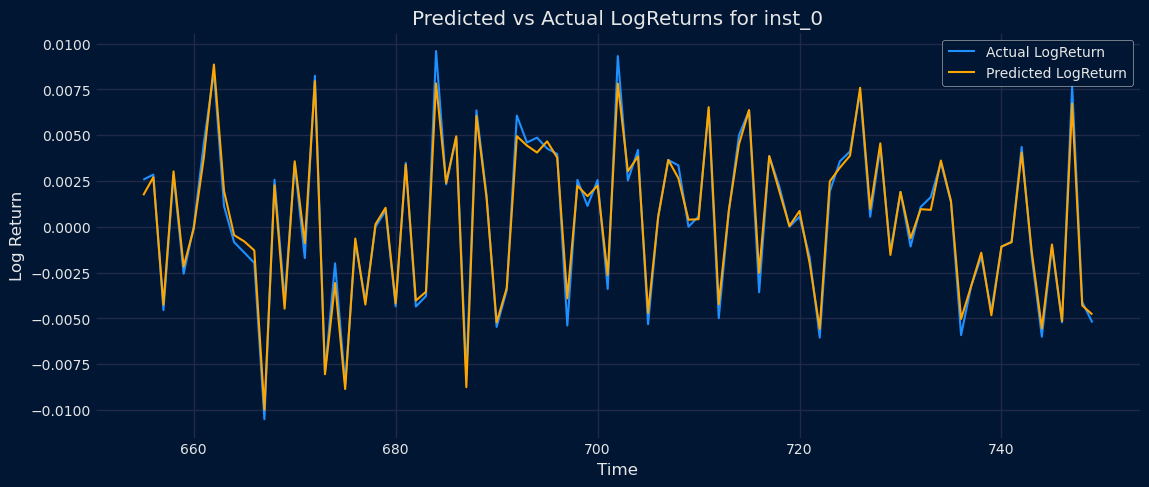

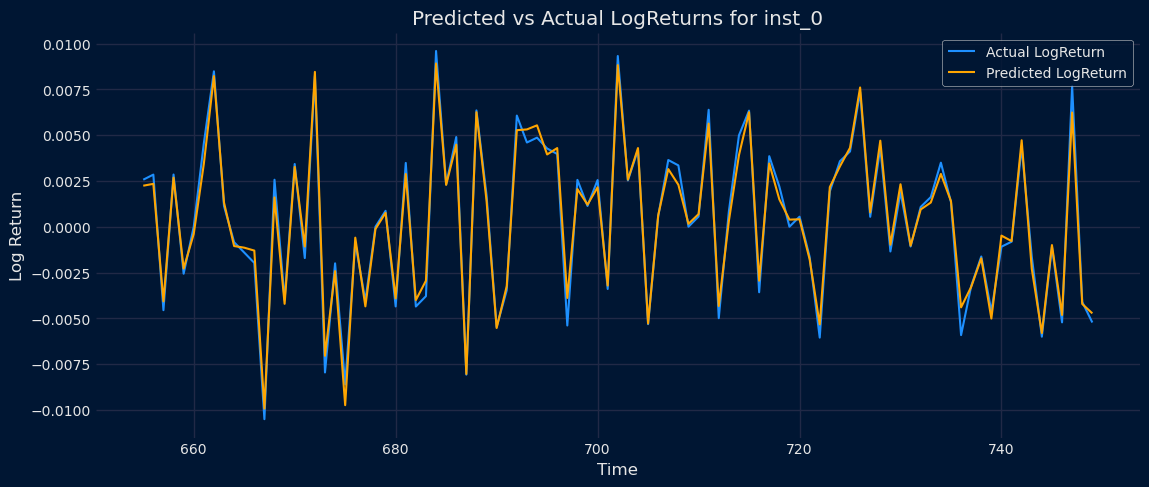

In [35]:
plotPredictedVsActualLogReturns(predictions_tuned, "inst_0")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns_hgbr, "inst_0")

Cant really tell a difference

Save our best params to a file:

In [36]:
import joblib
from datetime import datetime

best_forecaster.fit(
    series  = logReturns,   # Train the forecaster on all of our data
    exog    = exog_dict_for_logReturns,
)

fitted_scaler = best_forecaster.transformer_exog    # Save our fitted scaler


model_package = {
    "forecaster": best_forecaster,
    "best_params": best_params,
    "best_lags": best_lags,
    "window_features": window_features,
    "transformer_exog": fitted_scaler,
    "feature_names": exog_dict_for_logReturns["inst_0"].columns.tolist(),
}

now = datetime.now()
timestamp = now.strftime("date-%Y-%m-%d_time-%H-%M-%S")
filepath = f"./saved models/forecaster_model_{timestamp}.pkl"

# Save to file
joblib.dump(
    model_package,
    filepath,
)

╭──────────────────────────────── MissingValuesWarning ────────────────────────────────╮
│ NaNs detected in `X_train`. They have been dropped. If you want to keep them, set    │
│ `forecaster.dropna_from_series = False`. Same rows have been removed from `y_train`  │
│ to maintain alignment. This caused by series with interspersed NaNs.                 │
│                                                                                      │
│ Category : MissingValuesWarning                                                      │
│ Location :                                                                           │
│ C:\Users\jense\anaconda3\envs\Algothon-2025\Lib\site-packages\skforecast\recursive\_ │
│ forecaster_recursive_multiseries.py:1204                                             │
│ Suppress : warnings.simplefilter('ignore', category=MissingValuesWarning)            │
╰──────────────────────────────────────────────────────────────────────────────────────╯

['./saved models/forecaster_model_date-2025-07-04_time-12-58-25.pkl']

Some ideas:
- Predict vol over an n window and then steps = n as well to have a predictor of future volatilities of instruments for risk
- Predict log returns with step 2 together with step 1. then if they oppose say next log return is > 0, and the one after is < 0, might be a bad idea to buy because of the trading tax or something